In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils import *

import gensim
import logging
import warnings

import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.metrics import f1_score
from sklearn import linear_model

In [2]:
# Load training data
train_dataset = datasets.fetch_20newsgroups(subset='train', shuffle=True, remove=('headers','footers','quotes'))
train_news_df = pd.DataFrame({'news':train_dataset.data, 'target':train_dataset.target})
# replace target names from target numbers in our news data frame
train_news_df['target_name'] = train_news_df['target'].apply(lambda x: train_dataset.target_names[x])
tqdm.pandas()
train_news_df['news'] = train_news_df['news'].progress_apply(lambda x: clean_text(str(x)))
print(train_news_df.shape)

100%|██████████| 11314/11314 [00:11<00:00, 996.46it/s] 

(11314, 3)


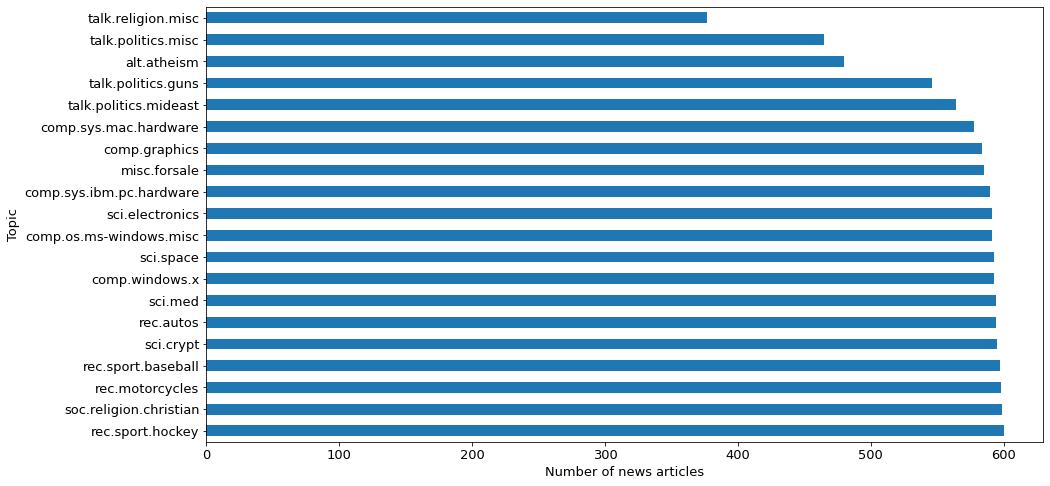

In [3]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 13})
train_news_df['target_name'].value_counts().plot(kind='barh')
plt.xlabel('Number of news articles')
plt.ylabel('Topic')
plt.show()

In [4]:
# Load testing data
test_dataset = datasets.fetch_20newsgroups(subset='test', shuffle=True, remove=('headers','footers','quotes'))
test_news_df = pd.DataFrame({'news':test_dataset.data, 'target':test_dataset.target})
# replace target names from target numbers in our news data frame
test_news_df['target_name'] = test_news_df['target'].apply(lambda x: test_dataset.target_names[x])
tqdm.pandas()
test_news_df['news'] = test_news_df['news'].progress_apply(lambda x: clean_text(str(x)))
print(test_news_df.shape)

100%|██████████| 7532/7532 [00:06<00:00, 1137.19it/s]

(7532, 3)


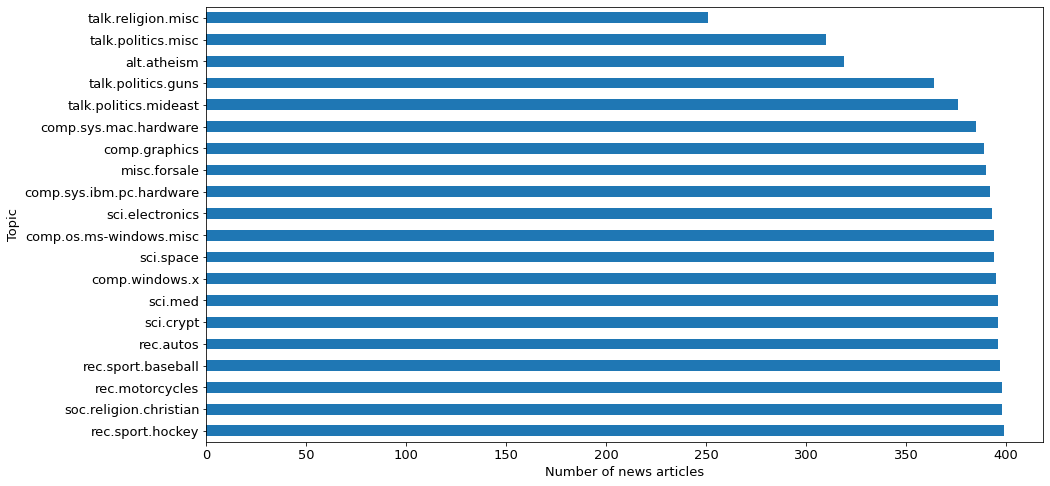

In [5]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 13})
test_news_df['target_name'].value_counts().plot(kind='barh')
plt.xlabel('Number of news articles')
plt.ylabel('Topic')
plt.show()

In [6]:
def trigrams(words, bi_min=15, tri_min=10):
    trigram = gensim.models.Phrases(words, min_count = bi_min)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return trigram_mod

In [7]:
def get_corpus(df):
    """
    Get Trigram Model, Corpus, id2word mapping
    """
    
    df['news'] = strip_newline(df.news)
    words = list(sent_to_words(df.news))
    words = remove_stopwords(words)
    trigram = trigrams(words)
    trigram = [trigram[review] for review in words]
#     lemma = lemmatization(bigram)
    id2word = gensim.corpora.Dictionary(trigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in trigram]
    return corpus, id2word, trigram

In [8]:
train_corpus4, train_id2word4, bigram_train4 = get_corpus(train_news_df)

## Topic Models

In [9]:
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_train4 = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus4,
                           num_topics=20,
                           id2word=train_id2word4,
                           chunksize=100,
                           workers=7, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)
    lda_train4.save('lda_train4.model')

In [10]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_train4, texts=bigram_train4, dictionary=train_id2word4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.5653614065111018

### Make vectors

In [11]:
train_vecs = []
for i in range(len(train_news_df)):
    top_topics = lda_train4.get_document_topics(train_corpus4[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    # topic_vec.extend([train_news_df.iloc[i].target_name]) # news article category
    topic_vec.extend([len(train_news_df.iloc[i].news)]) # length review
    train_vecs.append(topic_vec)

In [12]:
X = np.array(train_vecs)
y = np.array(train_news_df.target)

with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)

with open('X.pkl', 'wb') as f:
    pickle.dump(X, f)

### Final 5-fold CV loop for training

In [13]:
kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1,  = [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)

    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='micro'))
    
    # Logistic Regression Mini-Batch SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='micro'))
    
    # SGD Modified Huber
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='micro'))

print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SVM Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')

Logistic Regression Val f1: 0.425 +- 0.016
Logisitic Regression SGD Val f1: 0.377 +- 0.012
SVM Huber Val f1: 0.092 +- 0.081
